In [1]:
!pip install sunpy[all] lime

from IPython.display import clear_output
clear_output()

In [2]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.mlab as mlab
import pandas as pd
import scipy.stats
import requests
import urllib
import json
from datetime import datetime as dt_obj
from datetime import timedelta
from sklearn import svm
import lime
from sklearn.model_selection import StratifiedKFold
from sunpy.time import TimeRange
from sunpy.net import Fido, attrs as a

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
positive = pd.read_csv('/workspaces/flare-cme-association/2018/positive_2018.csv')
positive["CME"] = 1
negative = pd.read_csv('/workspaces/flare-cme-association/2018/negative_2018.csv')
negative["CME"] = 0

In [5]:
data = pd.concat([positive, negative],ignore_index=True)

In [6]:
data

,USFLUX,MEANGBT,MEANJZH,MEANPOT,SHRGT45,TOTUSJH,MEANGBH,MEANALP,MEANGAM,MEANGBZ,...,TOTPOT,MEANSHR,AREA_ACR,R_VALUE,ABSNJZH,HARPNUM,NOAA_ARS,GOES_Class,Peak_Time,CME
0,2.246101e+22,107.736,0.021724,15533.100,54.882,2975.118,77.983,0.041413,59.541,117.582,...,7.077275e+23,50.329,945.314636,4.805,745.287,377,11158,X2.2,2011.02.14_01:56_TAI,1
1,2.235615e+22,93.863,-0.001943,10914.060,44.178,1636.710,56.639,-0.003942,50.680,99.163,...,4.733711e+23,43.479,961.502686,4.303,63.441,401,11166,M2.0,2011.03.06_14:30_TAI,1
2,6.039302e+22,91.233,0.007535,9912.353,29.044,4229.148,49.560,0.015028,41.150,100.010,...,1.074422e+24,35.873,1934.446167,4.865,615.008,393,11164,M3.7,2011.03.06_20:12_TAI,1
3,2.384940e+22,109.706,0.009620,3703.910,13.500,1505.331,47.602,0.030907,34.321,110.939,...,1.879337e+23,28.525,970.551636,3.971,367.530,637,11226,M2.5,2011.06.06_06:41_TAI,1
4,1.989983e+22,109.891,0.032849,12062.610,44.090,2547.054,73.681,0.079865,53.270,115.866,...,5.269515e+23,43.929,1259.099854,4.777,1080.528,750,11261,M6.0,2011.08.02_13:48_TAI,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,5.405734e+22,96.225,-0.040161,17940.450,40.353,6883.232,63.221,-0.057003,47.062,110.593,...,1.584434e+24,41.244,1767.386841,5.134,2670.696,7115,12673,M1.3,2017.09.07_02:24_TAI,0
441,5.613295e+22,93.027,-0.038322,15304.870,35.437,5842.066,57.352,-0.061129,45.110,106.716,...,1.433866e+24,39.519,1905.817749,5.048,2703.341,7115,12673,M2.9,2017.09.07_15:47_TAI,0
442,5.941742e+22,85.360,-0.023854,12979.840,31.876,5518.212,52.930,-0.039883,42.963,98.952,...,1.299920e+24,37.017,1836.984009,4.914,1798.802,7115,12673,M2.1,2017.09.07_23:45_TAI,0
443,5.996130e+22,88.774,-0.020632,13169.540,30.936,5637.013,54.109,-0.033380,42.638,104.543,...,1.289169e+24,36.550,1864.373535,4.874,1520.726,7115,12673,M1.1,2017.09.08_04:28_TAI,0


## Plotting histograms to see the variability of the data

In [7]:
positive.head()

,USFLUX,MEANGBT,MEANJZH,MEANPOT,SHRGT45,TOTUSJH,MEANGBH,MEANALP,MEANGAM,MEANGBZ,...,TOTPOT,MEANSHR,AREA_ACR,R_VALUE,ABSNJZH,HARPNUM,NOAA_ARS,GOES_Class,Peak_Time,CME
0,2.246101e+22,107.736,0.021724,15533.100,54.882,2975.118,77.983,0.041413,59.541,117.582,...,7.077275e+23,50.329,945.314636,4.805,745.287,377,11158,X2.2,2011.02.14_01:56_TAI,1
1,2.235615e+22,93.863,-0.001943,10914.060,44.178,1636.710,56.639,-0.003942,50.680,99.163,...,4.733711e+23,43.479,961.502686,4.303,63.441,401,11166,M2.0,2011.03.06_14:30_TAI,1
2,6.039302e+22,91.233,0.007535,9912.353,29.044,4229.148,49.560,0.015028,41.150,100.010,...,1.074422e+24,35.873,1934.446167,4.865,615.008,393,11164,M3.7,2011.03.06_20:12_TAI,1
3,2.384940e+22,109.706,0.009620,3703.910,13.500,1505.331,47.602,0.030907,34.321,110.939,...,1.879337e+23,28.525,970.551636,3.971,367.530,637,11226,M2.5,2011.06.06_06:41_TAI,1
4,1.989983e+22,109.891,0.032849,12062.610,44.090,2547.054,73.681,0.079865,53.270,115.866,...,5.269515e+23,43.929,1259.099854,4.777,1080.528,750,11261,M6.0,2011.08.02_13:48_TAI,1


In [8]:
data = data.drop(['HARPNUM','NOAA_ARS','GOES_Class','Peak_Time'], axis=1)

<Axes: >

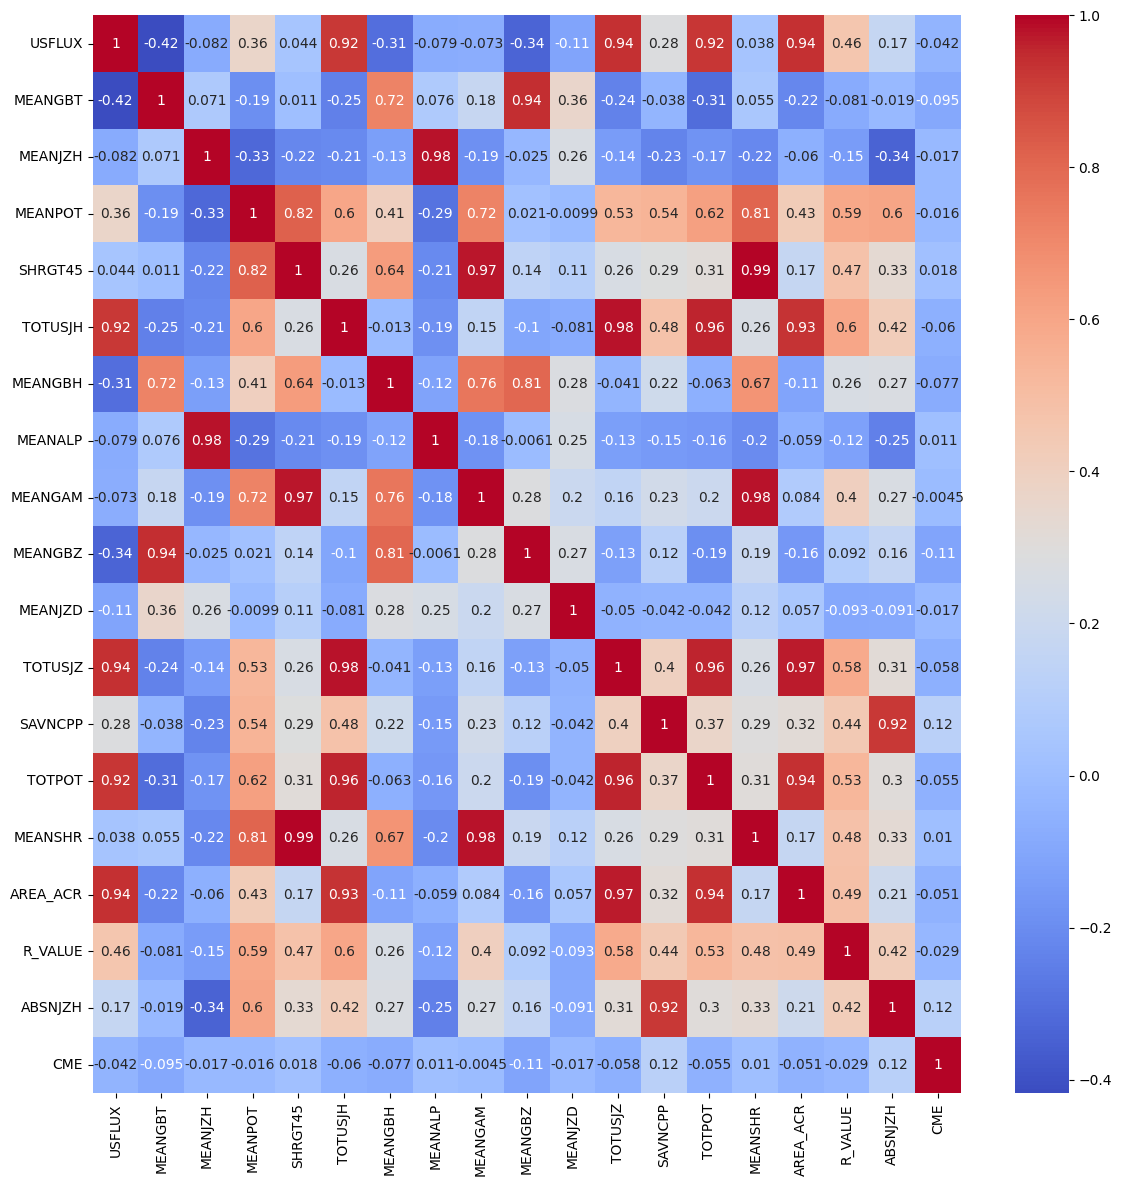

In [9]:
import seaborn as sns
plt.figure(figsize=(14,14))
sns.heatmap(data.corr(),annot=True,cmap="coolwarm")

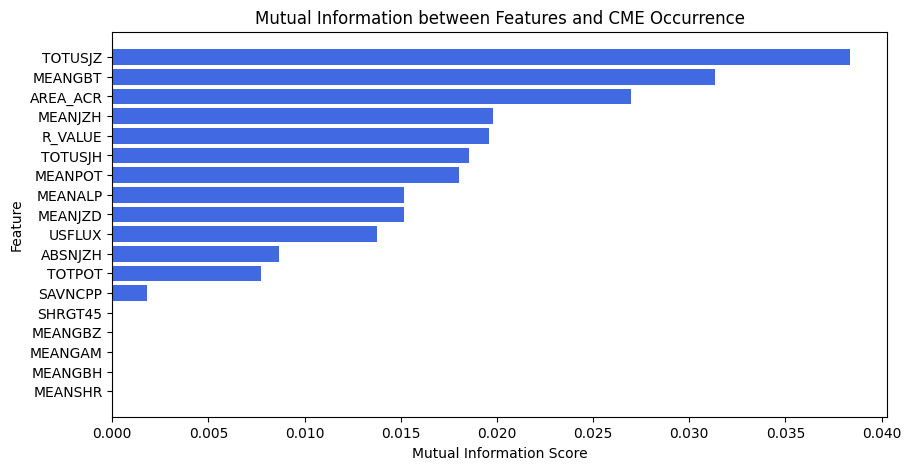

     Feature  MI Score
11   TOTUSJZ  0.038378
1    MEANGBT  0.031356
15  AREA_ACR  0.026973
2    MEANJZH  0.019780
16   R_VALUE  0.019574
5    TOTUSJH  0.018531
3    MEANPOT  0.018007
7    MEANALP  0.015185
10   MEANJZD  0.015151
0     USFLUX  0.013782
17   ABSNJZH  0.008674
13    TOTPOT  0.007738
12   SAVNCPP  0.001792
4    SHRGT45  0.000000
9    MEANGBZ  0.000000
8    MEANGAM  0.000000
6    MEANGBH  0.000000
14   MEANSHR  0.000000


In [10]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

X = data.drop(columns=['CME'])
y = data['CME']

# Normalize features (recommended for MI computation)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute Mutual Information scores
mi_scores = mutual_info_classif(X_scaled, y, random_state=42)

# Convert to a DataFrame for easy visualization
mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by="MI Score", ascending=False)

# Plot results
plt.figure(figsize=(10, 5))
plt.barh(mi_df['Feature'], mi_df['MI Score'], color="royalblue")
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.title("Mutual Information between Features and CME Occurrence")
plt.gca().invert_yaxis()  # Highest MI at the top
plt.show()

# Print top MI scores
print(mi_df)

In [11]:
datami = data.drop(["MEANGBZ","MEANSHR","MEANJZD","ABSNJZH","MEANJZH","TOTUSJH","SHRGT45"],axis = 1)

<Axes: >

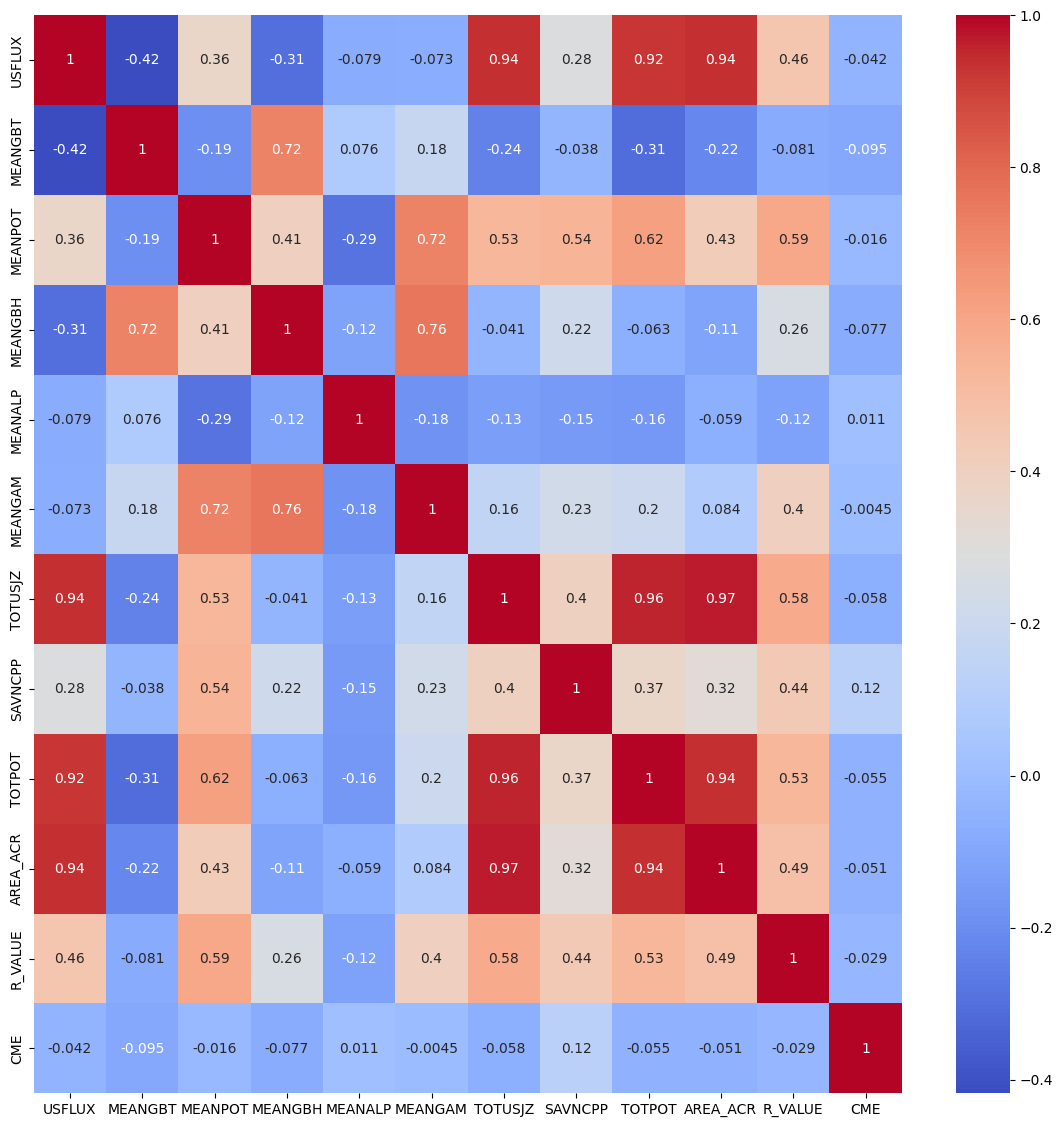

In [12]:
import seaborn as sns
plt.figure(figsize=(14,14))
sns.heatmap(datami.corr(),annot=True,cmap="coolwarm")

## Logistic Regression


In [13]:
datami.describe()

,USFLUX,MEANGBT,MEANPOT,MEANGBH,MEANALP,MEANGAM,TOTUSJZ,SAVNCPP,TOTPOT,AREA_ACR,R_VALUE,CME
count,4.450000e+02,445.000000,445.000000,445.000000,445.000000,445.000000,4.450000e+02,4.450000e+02,4.450000e+02,445.000000,445.000000,445.000000
mean,4.704941e+22,97.440038,11042.074894,57.499267,-0.002584,46.630834,6.927960e+13,2.354060e+13,1.092627e+24,1857.325804,4.640663,0.175281
std,3.689637e+22,13.685709,4729.748451,11.530053,0.031672,7.646838,4.698548e+13,2.190610e+13,1.077633e+24,1382.667940,0.643919,0.380635
min,8.884723e+20,61.379000,800.379700,24.736000,-0.101044,22.653000,1.954238e+12,1.069003e+12,6.820719e+21,33.391842,0.000000,0.000000
25%,2.371542e+22,89.433000,7195.446000,49.154000,-0.019562,41.327000,3.839320e+13,7.843014e+12,3.704313e+23,1020.223389,4.415000,0.000000
50%,3.716128e+22,97.398000,10883.050000,56.840000,-0.004562,46.577000,5.755064e+13,1.603186e+13,7.779750e+23,1519.661499,4.768000,0.000000
75%,5.699735e+22,106.427000,14309.380000,65.630000,0.013296,52.838000,8.462266e+13,3.322950e+13,1.386464e+24,2069.264893,5.008000,0.000000
max,1.963940e+23,144.854000,25132.400000,91.622000,0.108773,61.987000,2.403113e+14,9.884022e+13,5.276354e+24,7142.945801,5.486000,1.000000


In [14]:
from sklearn.model_selection import train_test_split

X = datami.drop(columns=['CME'])
y = datami['CME']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = LogisticRegression(class_weight="balanced",random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6966292134831461


In [17]:
TP, FP, FN, TN = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))

TSS = (TP / (TP + FN)) - (FP / (FP + TN))
print(TSS)

Confusion Matrix:
[[51 22]
 [ 5 11]]
0.24404761904761907


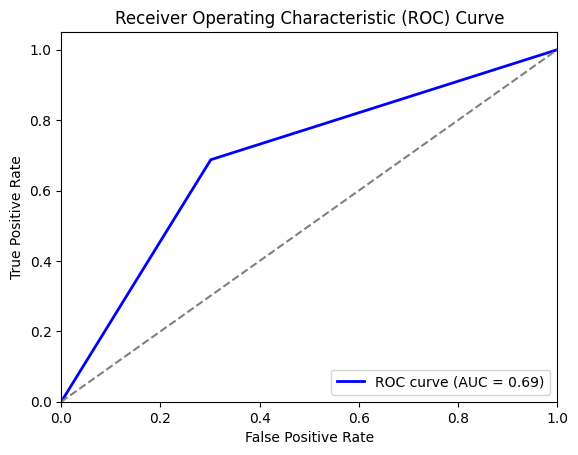

In [18]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Random Forest

In [19]:
from sklearn.model_selection import train_test_split

X = datami.drop(columns=['CME'])
y = datami['CME']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for ROC curve

# Compute metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
TP, FP, FN, TN = confusion_matrix(y_test, y_pred_rf).ravel()
TSS_rf = (TP / (TP + FN)) - (FP / (FP + TN))

print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print(f"Random Forest TSS: {TSS_rf:.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Accuracy: 0.76
Random Forest TSS: -0.19
Confusion Matrix:
[[68  5]
 [16  0]]


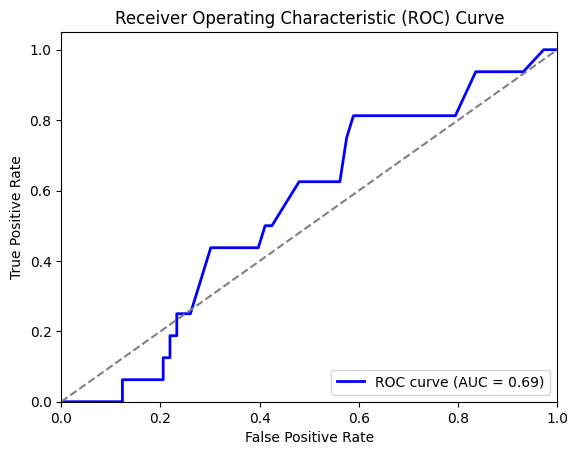

In [22]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()